## Bibliotecas

In [20]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial import distance_matrix
from adjustText import adjust_text

## Datos

In [21]:
# Ruta al archivo
file_path = "../data/Towns_HB_2024-08-14.xlsx"

# Leer todas las hojas como un diccionario {nombre_hoja: DataFrame}
all_sheets = pd.read_excel(file_path, sheet_name=None)

# Filtrar solo las hojas que tienen datos (al menos una fila no vacía)
non_empty_sheets = {name: df for name, df in all_sheets.items() if not df.dropna(how='all').empty}

# Mostrar nombres de hojas con datos
print(f"Hojas con datos: {list(non_empty_sheets.keys())}")

Hojas con datos: ['Towns', 'Triple Alliance towns', 'Tenochtitlan', 'Zempoala', '79 Destinations', 'Tecpilpan']


In [22]:
df_towns = non_empty_sheets["Towns"]
df_triple_alliance = non_empty_sheets["Triple Alliance towns"]
df_tenochtitlan = non_empty_sheets["Tenochtitlan"]
df_zempoala = non_empty_sheets["Zempoala"]
df_79 = non_empty_sheets["79 Destinations"]
df_tecpilpan = non_empty_sheets["Tecpilpan"]

### Definir coordenadas y pueblos

In [23]:
df_towns.columns

Index(['Clave', 'Toponym', 'PopSV', 'PopJV', 'Population', 'PopulationRank',
       'Pop-Ref', 'Revisado', 'Homonym', 'idGibson', 'idGA', 'idHB', 'idSV',
       'idHicks', 'ModernName', 'OtherNames', 'Municipality', 'State',
       'Latitude', 'Longitude', 'CoordSource', 'Ethnicity', 'Politics',
       'Realm', 'Estatus', 'SubjectTo', 'PoliticalCode', 'PoliticalRank',
       'Territory', 'nSubjectTowns', 'TerritorialRank', 'Military', 'Tribute',
       'Tributaries', 'Economy', 'Market', 'EarlyMartekStatus',
       'LateMarketStatus', 'Dock', 'CeremonialCenter', 'Other', 'Bibliography',
       'Observations', 'SourcePlacename', 'NameTranslation', 'TranslatedBy',
       'SourceGlyph', 'ChangeName'],
      dtype='object')

In [24]:
coords = df_towns[["Longitude", "Latitude"]].values
names = df_towns["Toponym"].values

## Graficar

In [27]:

def plot_points(coords, names):
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.scatter(coords[:, 0], coords[:, 1], color='blue', s=50)

    texts = []
    for i, (x, y) in enumerate(coords):
        texts.append(ax.text(x, y, names[i], fontsize=8))

    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")
    ax.set_title("Pueblos: solo puntos")
    ax.axis("equal")
    ax.grid(True)

    adjust_text(
        texts,
        ax=ax,
        only_move={'points': 'y', 'texts': 'xy'},
        arrowprops=dict(
            arrowstyle='->',
            color='gray',
            lw=0.5,
            shrinkA=10
        ),
        expand_points=(1.2, 1.2),
        force_text=0.5,
        force_points=0.2
    )

    plt.show()

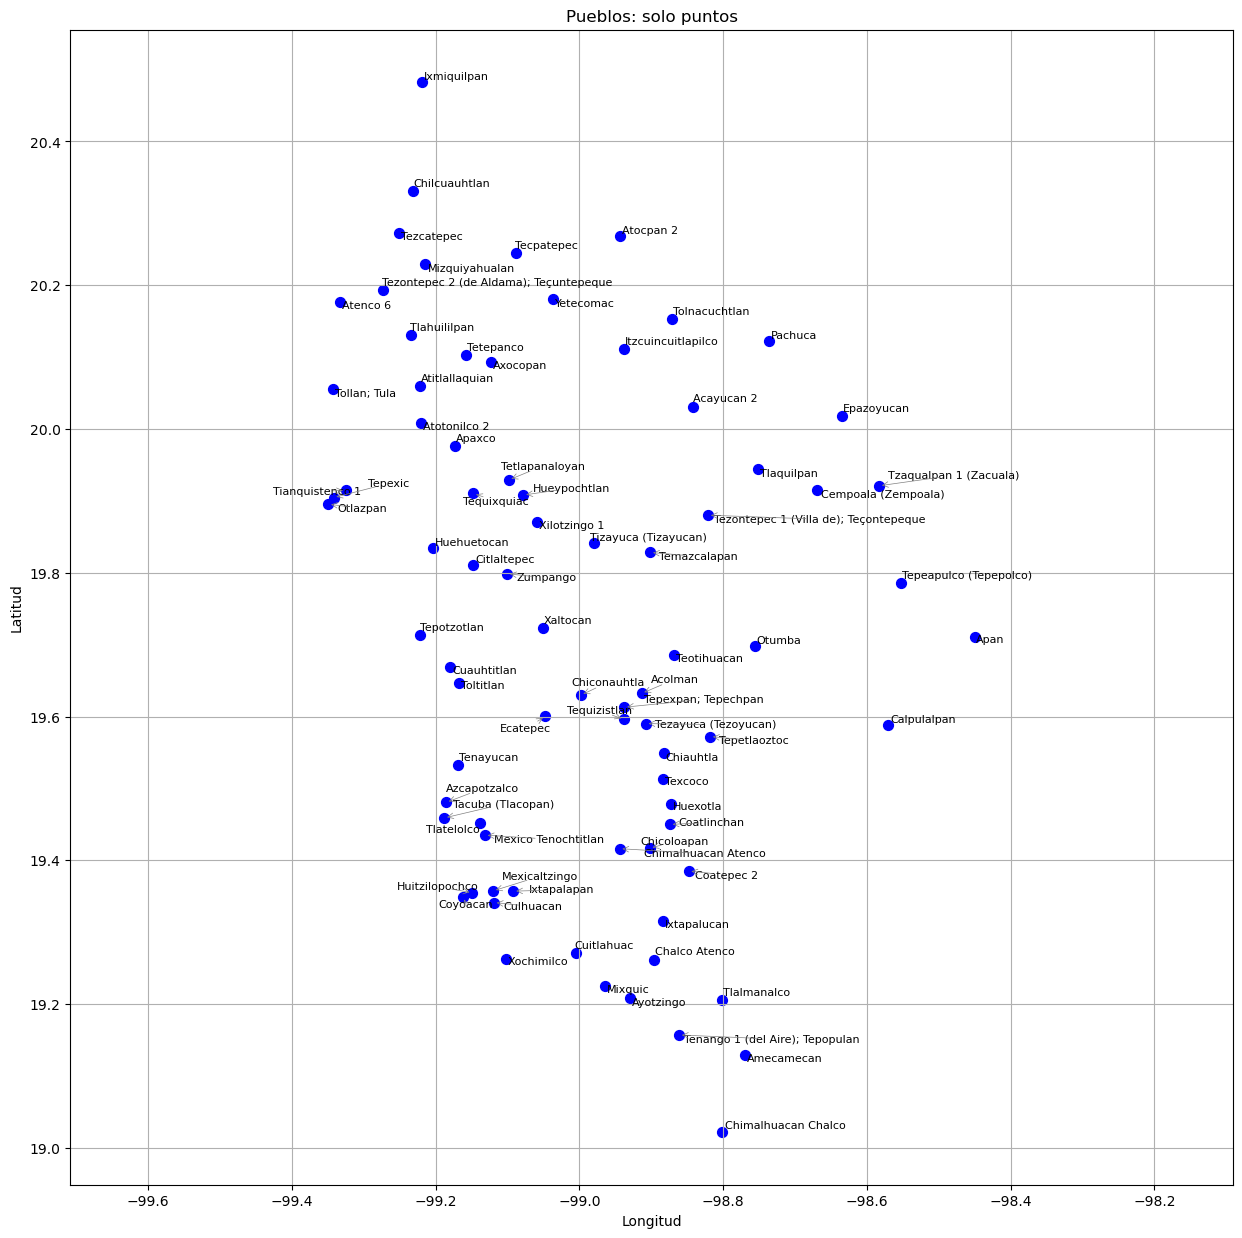

In [28]:
plot_points(coords, names)

### Revisar una distancia de un nodo

In [8]:
def plot_beta_tangent_circles(coords, names, i=7, j=13, beta=1.0):
    p1 = coords[i]
    p2 = coords[j]
    d = np.linalg.norm(p2 - p1)

    if beta < 1:
        raise ValueError("Beta debe ser ≥ 1 para una construcción válida.")

    r = (beta * d) / 2
    direction = (p2 - p1) / d

    center1 = p1 + direction * r
    center2 = p2 - direction * r

    fig, ax = plt.subplots(figsize=(10, 10))

    # Determinar qué puntos están dentro de los círculos
    in_lune = []
    out_lune = []
    for k, pk in enumerate(coords):
        if k in (i, j):
            continue  # No analizar los dos puntos principales
        dist1 = np.linalg.norm(pk - center1)
        dist2 = np.linalg.norm(pk - center2)
        if dist1 < r or dist2 < r:
            in_lune.append((pk, names[k]))
        else:
            out_lune.append((pk, names[k]))

    # Graficar puntos fuera de la luna
    if out_lune:
        x_out, y_out = zip(*[p for p, _ in out_lune])
        ax.scatter(x_out, y_out, color='lightgray', label='Otros pueblos fuera de la luna')
    
    # Graficar puntos dentro de la luna
    if in_lune:
        x_in, y_in = zip(*[p for p, _ in in_lune])
        ax.scatter(x_in, y_in, color='blue', label='Pueblos dentro de la luna')

    # Graficar los puntos evaluados
    ax.scatter([p1[0], p2[0]], [p1[1], p2[1]], color='red', label='Puntos evaluados', zorder=3)

    # Etiquetas
    ax.text(p1[0] + 0.0003, p1[1] + 0.0003, names[i], fontsize=9)
    ax.text(p2[0] + 0.0003, p2[1] + 0.0003, names[j], fontsize=9)

    # Círculos
    ax.add_patch(Circle(center1, r, color='blue', fill=False, linestyle='--', label=f"Círculo tangente a {names[i]}"))
    ax.add_patch(Circle(center2, r, color='green', fill=False, linestyle='--', label=f"Círculo tangente a {names[j]}"))

    # Línea entre puntos evaluados
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k--', alpha=0.5)

    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")
    ax.set_title(f"Círculos β = {beta} tangentes a '{names[i]}' y '{names[j]}'")
    ax.axis("equal")
    ax.grid(True)
    ax.legend()
    plt.show()


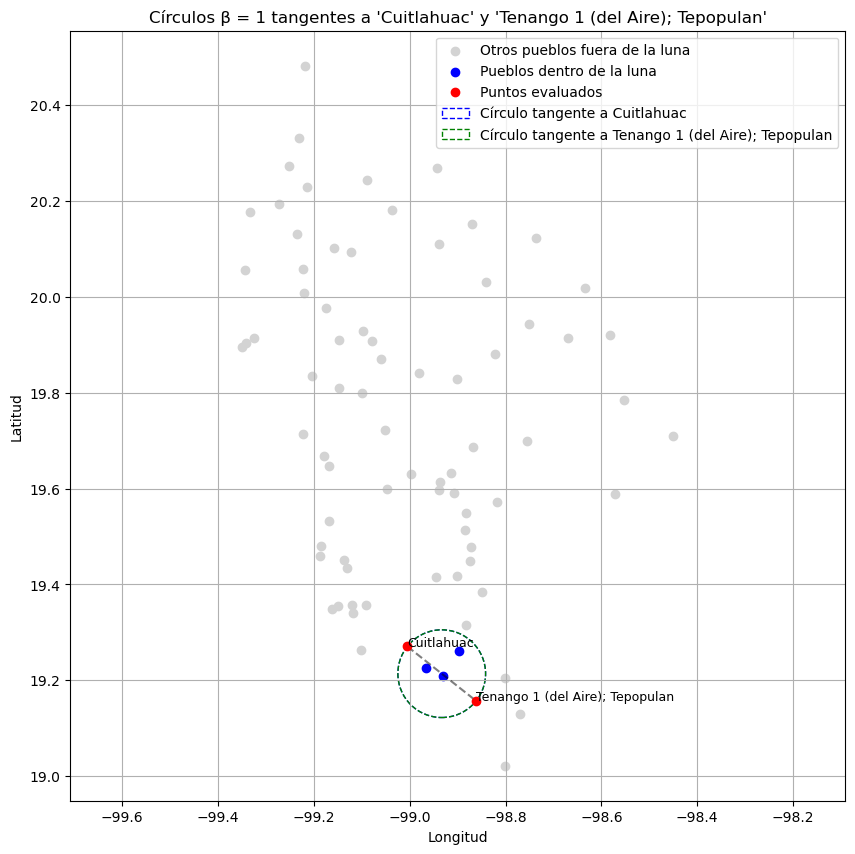

In [9]:
plot_beta_tangent_circles(coords, names, i=6, j=2, beta=1)

### Revisar todas las distancias de un solo nodo

In [10]:
def plot_beta_lunes_for_node(coords, names, i, beta=1.0):
    n = len(coords)
    p1 = coords[i]

    for j in range(n):
        if j == i:
            continue

        p2 = coords[j]
        d = np.linalg.norm(p2 - p1)
        if d == 0:
            continue

        r = (beta * d) / 2
        direction = (p2 - p1) / d
        center1 = p1 + direction * r
        center2 = p2 - direction * r

        # Clasificar puntos dentro y fuera de la luna
        in_lune = []
        out_lune = []
        for k, pk in enumerate(coords):
            if k in (i, j):
                continue
            dist1 = np.linalg.norm(pk - center1)
            dist2 = np.linalg.norm(pk - center2)
            if dist1 < r or dist2 < r:
                in_lune.append((pk, names[k]))
            else:
                out_lune.append((pk, names[k]))

        # Graficar
        fig, ax = plt.subplots(figsize=(8, 8))

        if out_lune:
            x_out, y_out = zip(*[p for p, _ in out_lune])
            ax.scatter(x_out, y_out, color='lightgray', label='Otros pueblos fuera de la luna')

        if in_lune:
            x_in, y_in = zip(*[p for p, _ in in_lune])
            ax.scatter(x_in, y_in, color='blue', label='Pueblos dentro de la luna')

        ax.scatter([p1[0], p2[0]], [p1[1], p2[1]], color='red', zorder=3)

        # Etiquetas
        ax.text(p1[0] + 0.0003, p1[1] + 0.0003, names[i], fontsize=9)
        ax.text(p2[0] + 0.0003, p2[1] + 0.0003, names[j], fontsize=9)

        # Círculos tangentes
        circle1 = Circle(center1, r, color='blue', fill=False, linestyle='--', label=f"Tangente a {names[i]}")
        circle2 = Circle(center2, r, color='green', fill=False, linestyle='--', label=f"Tangente a {names[j]}")
        ax.add_patch(circle1)
        ax.add_patch(circle2)

        # Línea entre los puntos evaluados
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'k--', alpha=0.5)

        ax.set_xlabel("Longitud")
        ax.set_ylabel("Latitud")
        ax.set_title(f"Luna β = {beta} entre '{names[i]}' y '{names[j]}'")
        ax.axis("equal")
        ax.grid(True)
        ax.legend()
        plt.show()


In [11]:
# plot_beta_lunes_for_node(coords, names, i=6, beta=1)

## Beta skeletons

In [12]:
def check_lune_for_node(coords, i, beta=1.0):
    n = len(coords)
    p1 = coords[i]
    result_vector = []

    for j in range(n):
        if j == i:
            result_vector.append(0)  # No self-loop; optional choice
            continue

        p2 = coords[j]
        d = np.linalg.norm(p2 - p1)
        if d == 0:
            result_vector.append(0)
            continue

        r = (beta * d) / 2
        direction = (p2 - p1) / d
        center1 = p1 + direction * r
        center2 = p2 - direction * r

        # Check if any other point lies in the lune (intersection of both circles)
        is_clear = 1
        for k in range(n):
            if k == i or k == j:
                continue
            pk = coords[k]
            dist1 = np.linalg.norm(pk - center1)
            dist2 = np.linalg.norm(pk - center2)
            if dist1 < r and dist2 < r:
                is_clear = 0  # Found a point in the lune
                break

        result_vector.append(is_clear)

    return result_vector


In [13]:
def beta_skeleton_adjacency_matrix(coords, beta=1.0):
    n = len(coords)
    matrix = np.zeros((n, n), dtype=int)

    for i in range(n):
        row = check_lune_for_node(coords, i, beta=beta)
        matrix[i] = row

    # Make sure the matrix is symmetric (undirected graph)
    matrix = np.minimum(matrix, matrix.T)
    
    return matrix

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
from adjustText import adjust_text

def plot_beta_skeleton_graph(coords, names, beta=1.0):
    # Get the adjacency matrix using the beta-skeleton rule
    adj_matrix = beta_skeleton_adjacency_matrix(coords, beta=beta)
    
    # Create graph
    G = nx.Graph()
    
    # Add nodes with positions and labels
    for i, (x, y) in enumerate(coords):
        G.add_node(i, pos=(x, y), label=names[i])
    
    # Add edges from adjacency matrix
    n = len(coords)
    for i in range(n):
        for j in range(i + 1, n):
            if adj_matrix[i, j] == 1:
                G.add_edge(i, j)

    # Plot
    pos = nx.get_node_attributes(G, 'pos')
    labels = nx.get_node_attributes(G, 'label')

    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, node_color='skyblue', with_labels=False, node_size=100)

    # ✅ Create texts before calling adjust_text
    texts = []
    for i, (x, y) in pos.items():
        texts.append(plt.text(x, y, labels[i], fontsize=8))

    # ✅ Adjust text positions to avoid overlaps
    adjust_text(
        texts,
        arrowprops=dict(
            arrowstyle='->',
            color='gray',
            lw=0.5,
            shrinkA=5  # Ensures arrows don’t touch the text
        ),
        expand_points=(1.2, 1.2),
        force_text=0.5,
        force_points=0.2
    )

    plt.title(f"Gráfica β-esqueleto (β = {beta})")
    plt.grid(True)
    plt.axis("equal")
    plt.show()


### $\beta = 1$, Gráfico de Gabriel

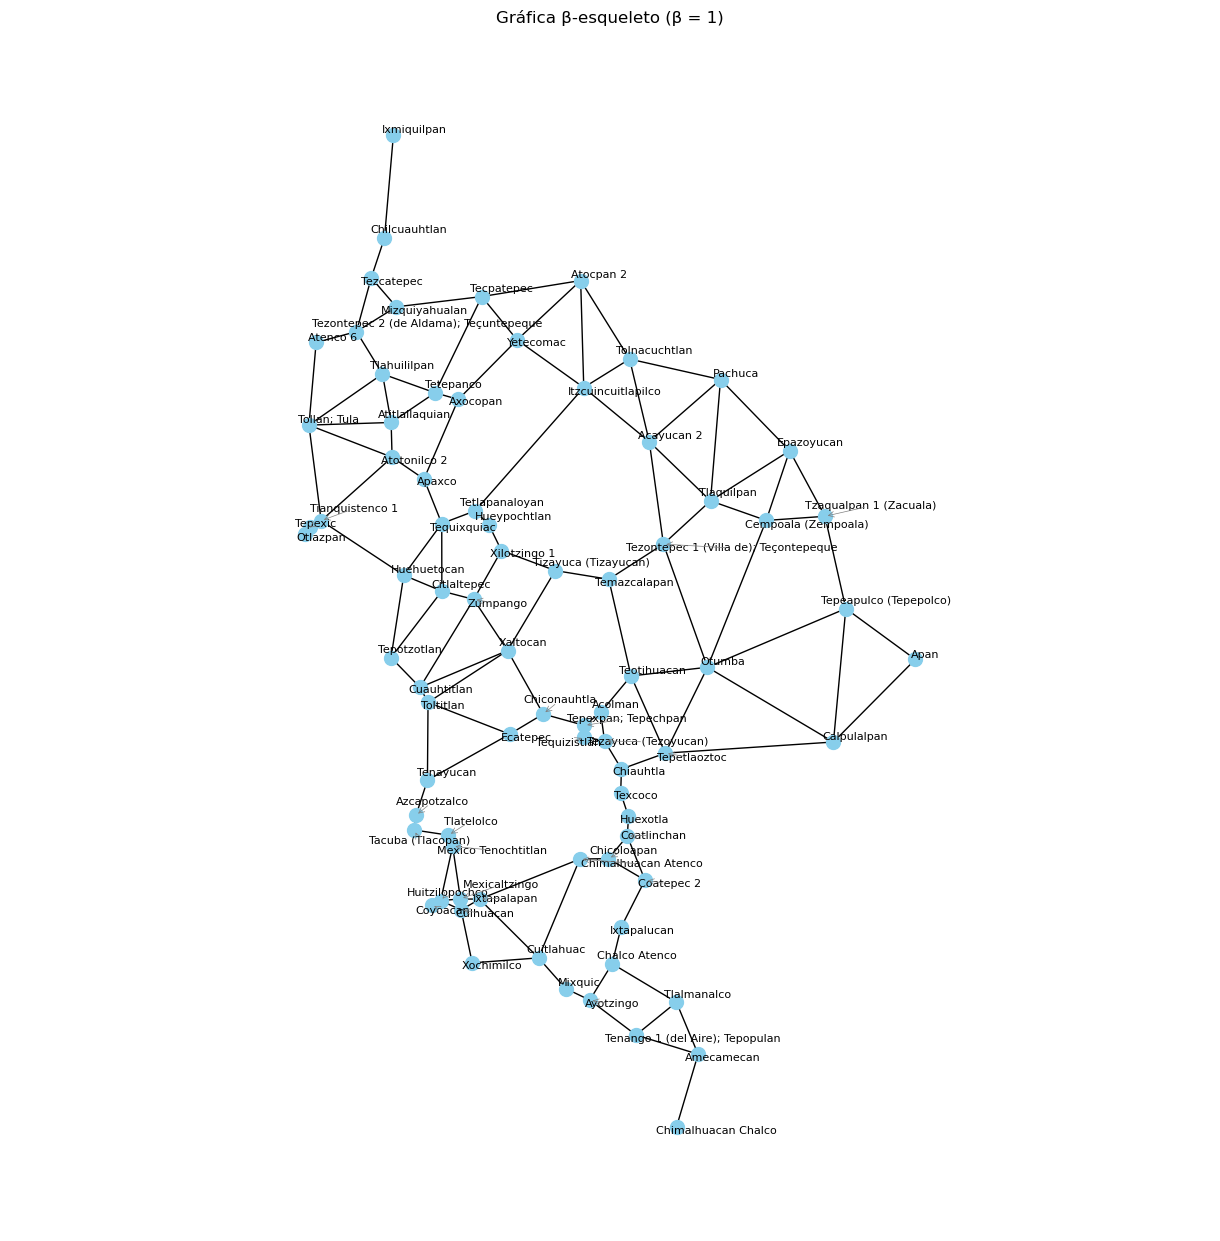

In [15]:
plot_beta_skeleton_graph(coords, names, beta=1)

### $\beta = 1.5$

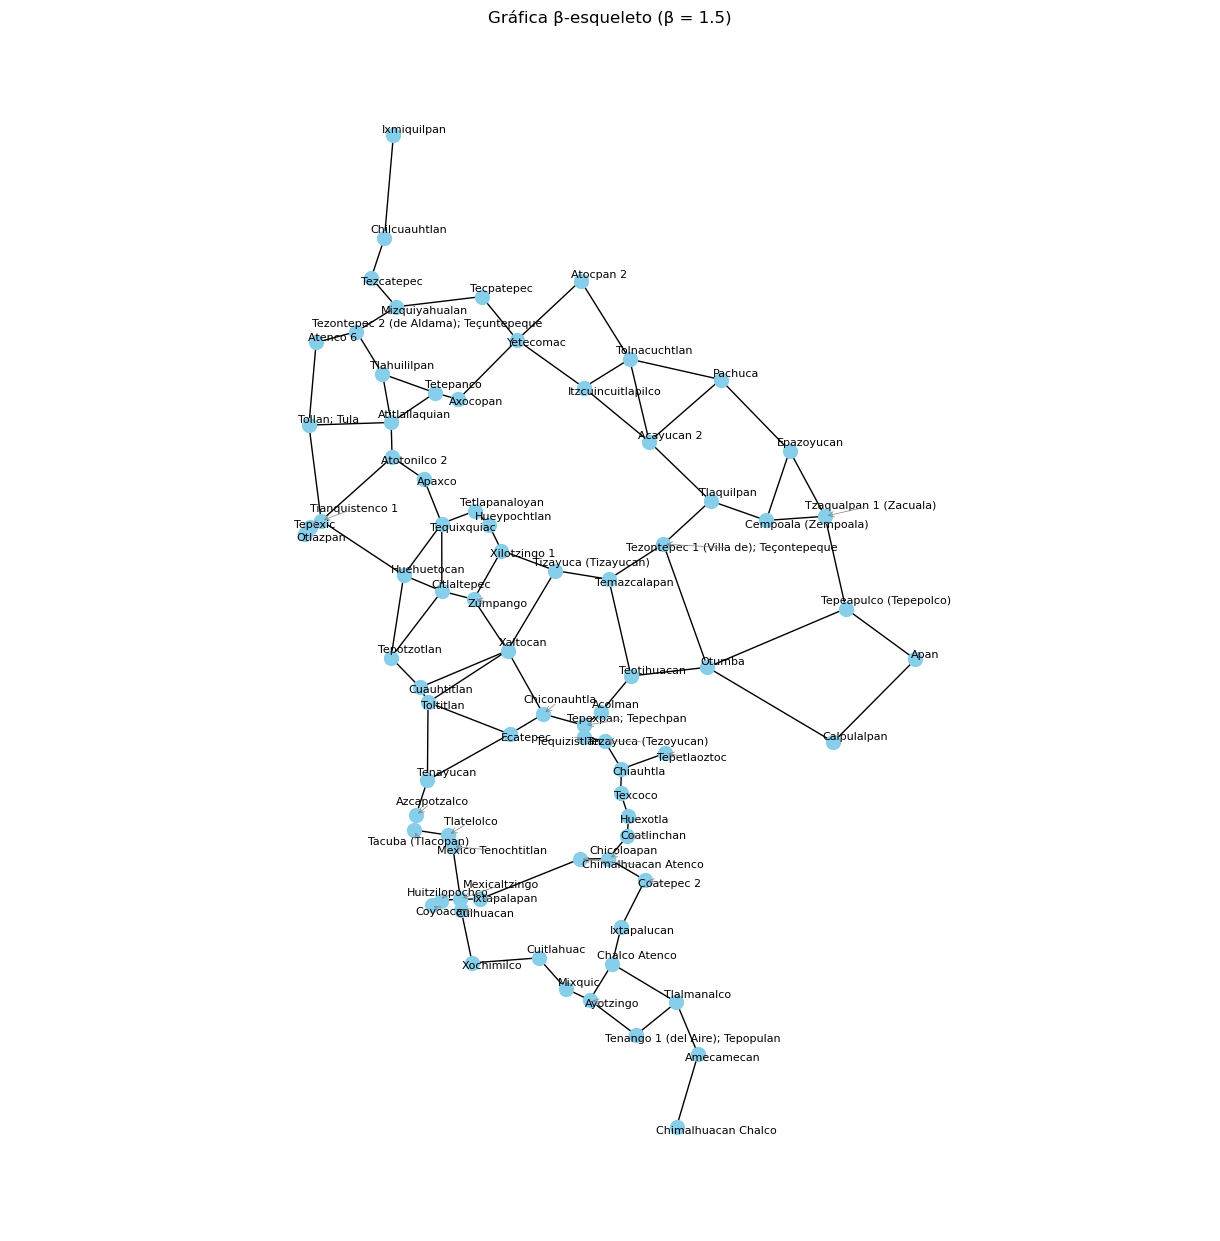

In [16]:
plot_beta_skeleton_graph(coords, names, beta=1.5)

### $\beta = 2$, Vecindad Relativa

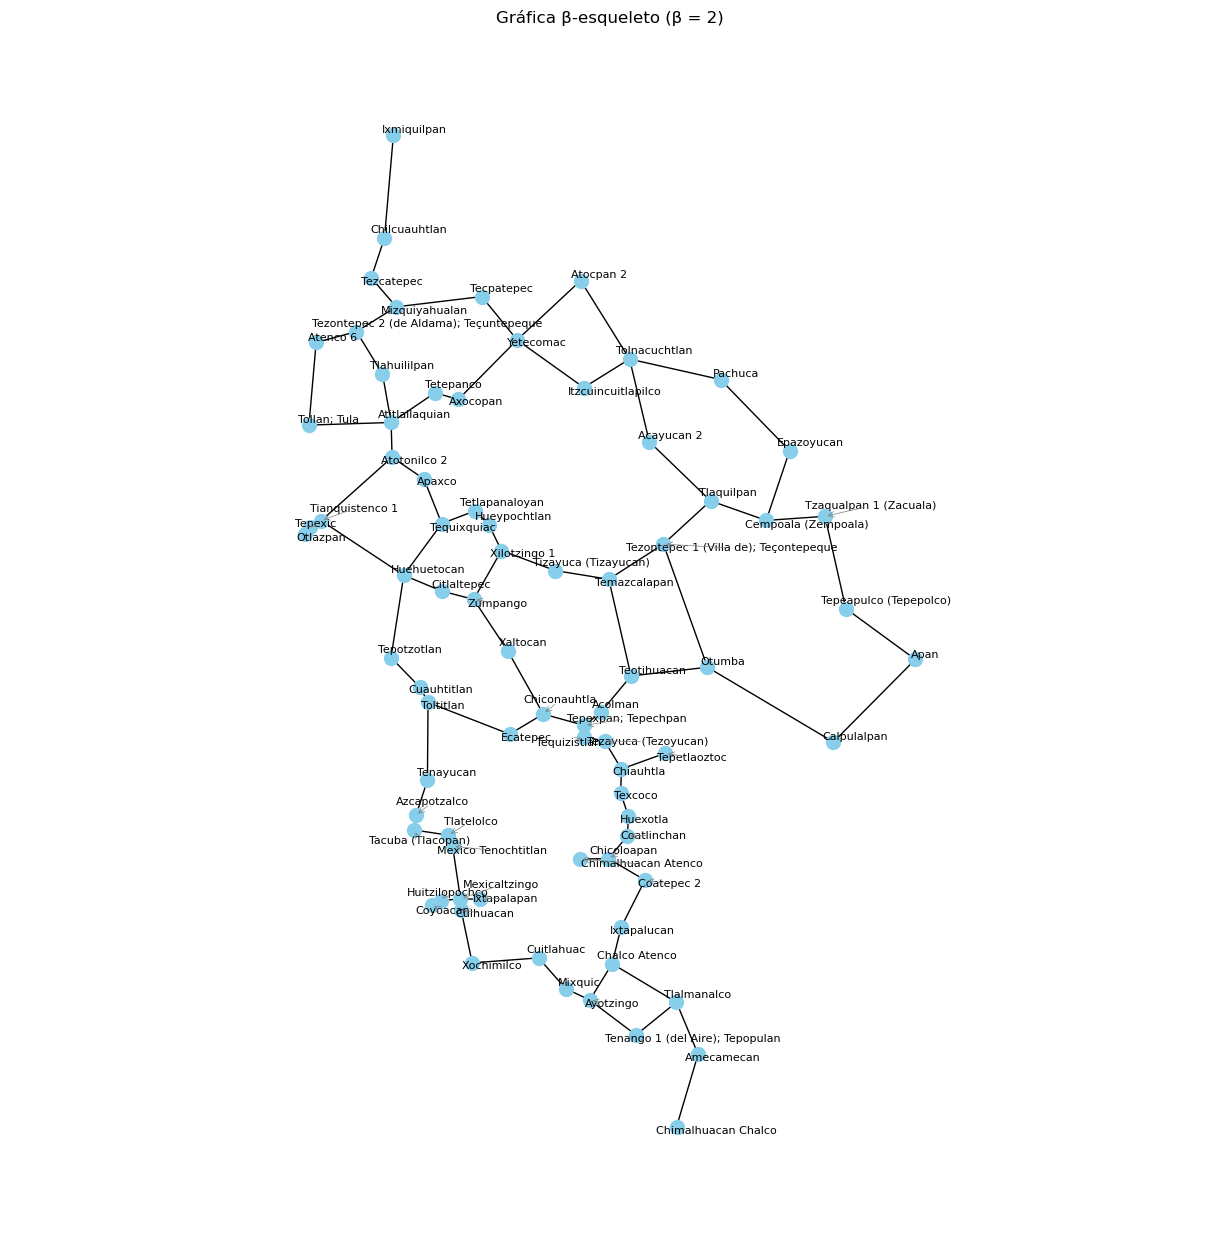

In [17]:
plot_beta_skeleton_graph(coords, names, beta=2)

# Lo paso a Grafo

In [29]:
# Assume `coords` is your (n, 2) numpy array of coordinates

# Step 1: Get the adjacency matrix with β = 1.0 (Gabriel Graph)
adj_matrix = beta_skeleton_adjacency_matrix(coords, beta=1.0)

# Step 2: Create a NetworkX graph from the adjacency matrix
G = nx.Graph()

# Step 3: Add nodes with their coordinates as attributes
for i, (x, y) in enumerate(coords):
    G.add_node(i, pos=(x, y))

# Step 4: Add edges where adj_matrix[i, j] == 1
n = len(coords)
for i in range(n):
    for j in range(i + 1, n):
        if adj_matrix[i, j] == 1:
            G.add_edge(i, j)

# Now G is your Gabriel Graph

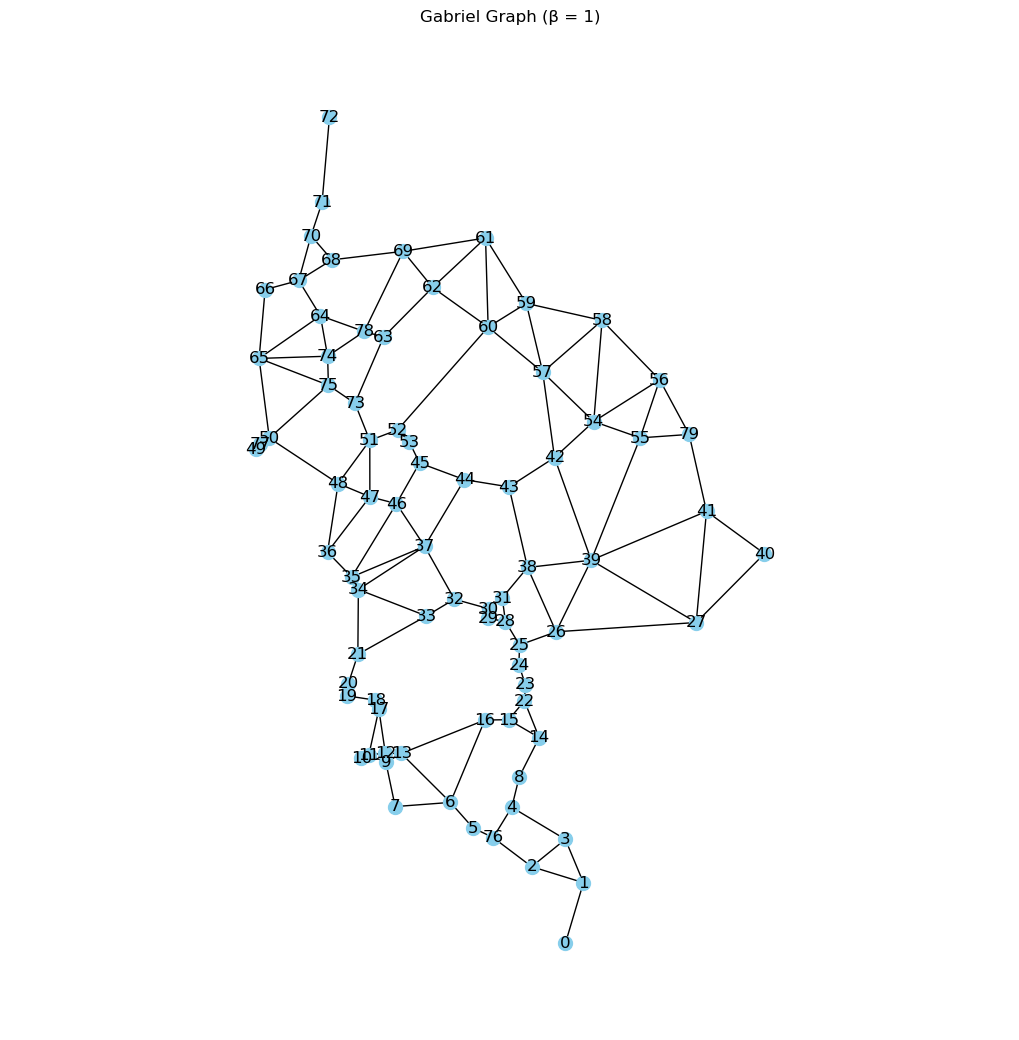

In [30]:
pos = nx.get_node_attributes(G, 'pos')

plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100)
plt.title("Gabriel Graph (β = 1)")
plt.axis("equal")
plt.grid(True)
plt.show()


## Asimetría Relativa

In [31]:
def compute_relative_asymmetry(graph):
    n = graph.number_of_nodes()
    RA = {}

    for node in graph.nodes():
        # Step 1: Get all shortest path lengths from this node
        lengths = nx.single_source_shortest_path_length(graph, node)

        # Step 2: Compute mean depth (excluding self-distance)
        total_depth = sum(length for target, length in lengths.items() if target != node)
        mdi = total_depth / (n - 1)

        # Step 3: Compute Relative Asymmetry (RA)
        if n > 2:
            RAi = (2 * (mdi - 1)) / (n - 2)
        else:
            RAi = 0  # handle trivial case of a 2-node graph

        RA[node] = RAi

    return RA


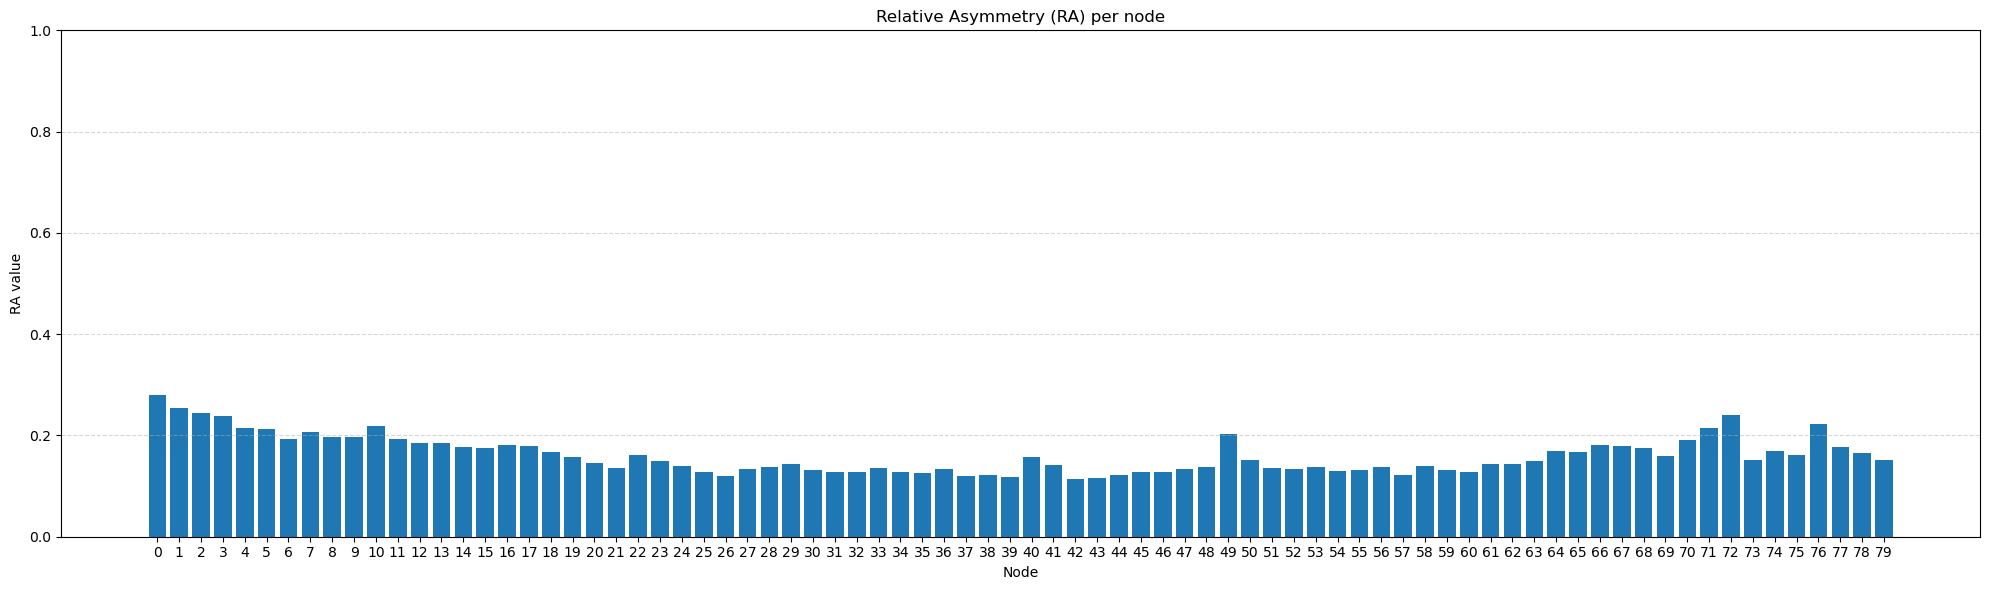

In [40]:
def plot_ra_column_chart(G):
    """
    Compute Relative Asymmetry (RA) for each node in graph G
    and display a bar chart of the values.
    """
    n = G.number_of_nodes()
    ra_vals = {}
    
    # ---- compute RA ----
    for node in G.nodes():
        lengths = nx.single_source_shortest_path_length(G, node)
        total_depth = sum(dist for tgt, dist in lengths.items() if tgt != node)
        mdi = total_depth / (n - 1)
        ra = (2 * (mdi - 1)) / (n - 2) if n > 2 else 0
        ra_vals[node] = ra

    # ---- prepare data for plotting ----
    nodes, values = zip(*sorted(ra_vals.items(), key=lambda x: x[0]))  # sorted by node id

    # ---- draw bar chart ----
    plt.figure(figsize=(20, 6))
    plt.bar(nodes, values)          # default color
    plt.xticks(nodes)               # show every node ID on x-axis
    plt.ylabel("RA value")
    plt.xlabel("Node")
    plt.title("Relative Asymmetry (RA) per node")
    plt.ylim(0, 1)                  # RA is in [0, 1]
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Example usage:
# G is the Gabriel graph you already built
plot_ra_column_chart(G)


In [49]:
def plot_graph_with_ra_colors(G, ra_values):
    pos = nx.get_node_attributes(G, 'pos')
    node_color = [ra_values[node] for node in G.nodes()]

    fig, ax = plt.subplots(figsize=(10, 10))

    # Draw the graph on the specific Axes
    nodes = nx.draw(
        G,
        pos,
        ax=ax,
        with_labels=True,
        node_color=node_color,
        node_size=200,
        cmap=plt.cm.plasma, #viridis, magma, coolwarm, plasma
        edge_color='gray'
    )

    # Create and add a colorbar to the same Axes
    sm = plt.cm.ScalarMappable(
        cmap=plt.cm.plasma,
        norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color))
    )
    sm.set_array([])  # Required only to avoid warnings in some versions
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label("Relative Asymmetry (RA)")

    ax.set_title("Gabriel Graph (β = 1) – Node Color by RA")
    ax.axis("equal")
    ax.grid(True)

    plt.show()


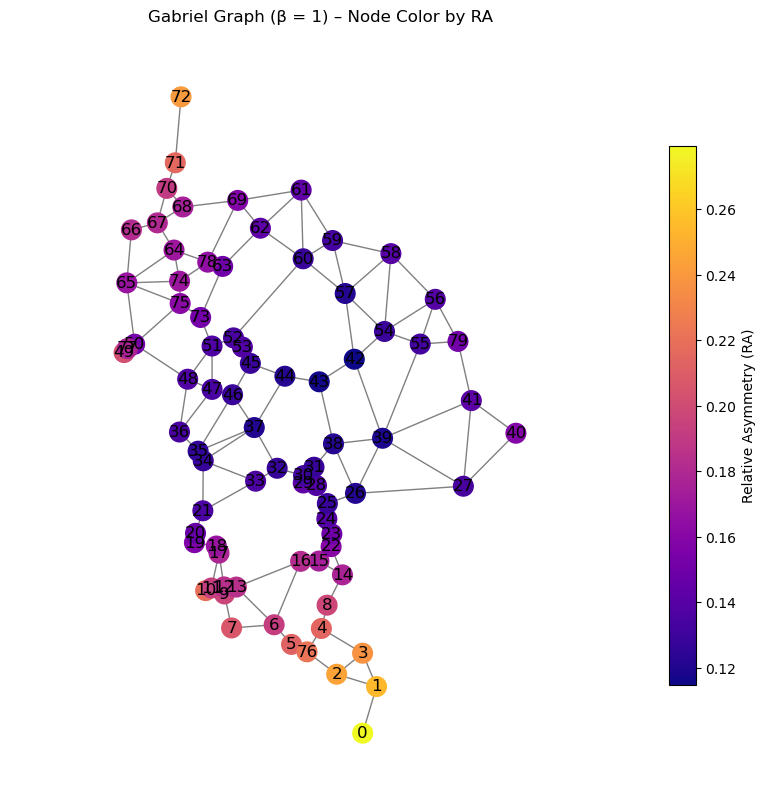

In [50]:
plot_graph_with_ra_colors(G, RA_values)

## Grado de control

In [51]:
def compute_control_values(G):
    """
    Compute the control value (grado de control) for each node in graph G.
    
    Returns:
        dict: {node: control_value}
    """
    control = {}
    for node in G.nodes():
        cv = sum(1 / G.degree(neighbor) for neighbor in G.neighbors(node))
        control[node] = cv
    return control


In [53]:
def plot_graph_with_control_colors(G, control_values):
    pos = nx.get_node_attributes(G, 'pos')
    node_color = [control_values[node] for node in G.nodes()]

    fig, ax = plt.subplots(figsize=(10, 10))

    # Draw graph with control values as node colors
    nodes = nx.draw(
        G,
        pos,
        ax=ax,
        with_labels=True,
        node_color=node_color,
        node_size=200,
        cmap=plt.cm.plasma,  # Options: viridis, magma, coolwarm, plasma
        edge_color='gray'
    )

    # Add colorbar
    sm = plt.cm.ScalarMappable(
        cmap=plt.cm.plasma,
        norm=plt.Normalize(vmin=min(node_color), vmax=max(node_color))
    )
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label("Grado de control (Control Value)")

    ax.set_title("Gabriel Graph (β = 1) – Node Color by Grado de Control")
    ax.axis("equal")
    ax.grid(True)

    plt.show()


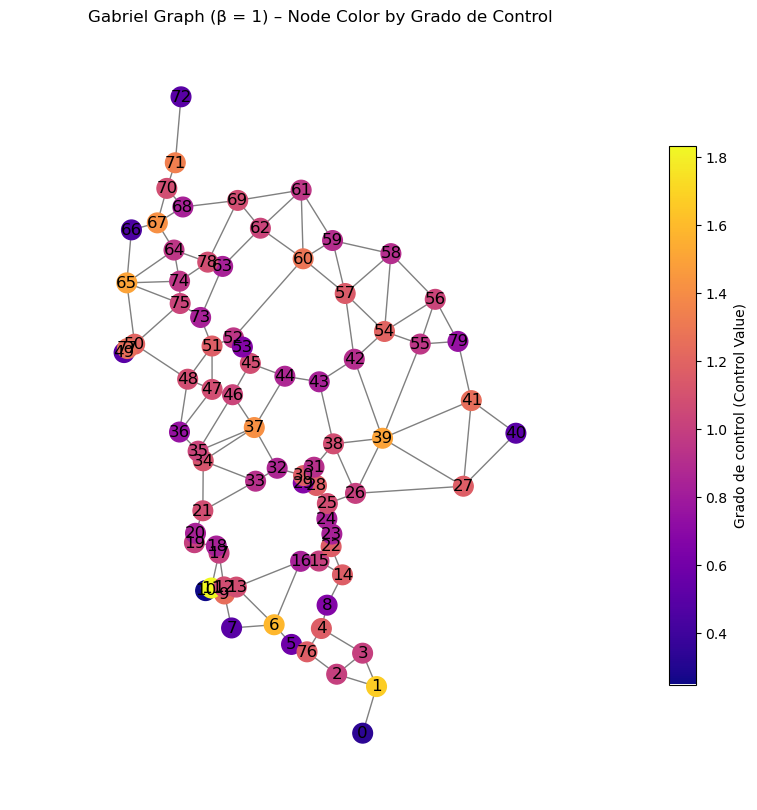

In [54]:
control_values = compute_control_values(G)
plot_graph_with_control_colors(G, control_values)
